In [3]:
from thllib import flylib as flb
from matplotlib import pyplot as plt
import numpy as np
import scipy
from thllib import util
import figurefirst as fifi
import scipy.signal
import local_project_functions as lpf
from IPython.display import SVG,display

In [4]:
%matplotlib inline

In [5]:
flynumbers = list(range(1389,1402))
flylist = [flb.NetFly(fnum,rootpath='/media/imager/FlyDataD/FlyDB/') for fnum in flynumbers]
l = [fly.open_signals() for fly in flylist]
#fly = flylist[4]
#fly.open_signals()

In [6]:
sorted_keys = sorted(flylist[0].spikestates.keys())

cull_list = [('left', 'bkg'),('right', 'bkg'),
            ('left', 'iii24'),('right', 'iii24'),
            ('left', 'nm'),('right', 'nm'),
            ('left', 'pr'),('right', 'pr'),
            ('left', 'tpd'),('right', 'tpd'),
            ('left', 'iii1'),('right', 'iii1'),
            ('left', 'i2'),('right', 'i2'),
            ('left', 'b1'),('right', 'b1'),
            ('left', 'b2'),('right', 'b2'),
            ('left', 'hg2'),('right', 'hg2'),
            ('left', 'hg3'),('right', 'hg3'),
            ('left', 'hg4'),('right', 'hg4')]

for cull in cull_list:
    sorted_keys.remove(cull)
#[sorted_keys.remove(cull) for cull in cull_list]

In [8]:
#set(fly.block_data.keys())

In [10]:
state_mtrxs = []
lmr = []
for fly in flylist:
    state_mtrx = np.vstack([fly.spikestates[key] for key in sorted_keys])
    #key = ('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0')
    #key = ('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=-8, b_y=0')
    key = ('common', 'idx', 'cl_blocks, g_x=-1, g_y=0 b_x=0, b_y=0')
    idx_list = fly.block_data[key]
    state_mtrxs.extend([np.array(state_mtrx[:,idx[300:]]) for idx in idx_list])
    lmr.extend([np.array(fly.left_amp)[idx[300:]]-np.array(fly.right_amp)[idx[300:]] 
                for idx in idx_list])

In [11]:
from sklearn.cluster import AffinityPropagation,DBSCAN,AgglomerativeClustering,KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [12]:
def dist(r1,r2):
    """distance metric for binary strings defined by 
    a 50/50 chance of flipping a single bit"""
    p1 = 1-0.5**np.sum(~(r1.astype(bool) == r2.astype(bool)))
    return p1

In [13]:
train_dset = np.hstack(state_mtrxs).T

In [14]:
np.shape(train_dset)

(6650, 8)

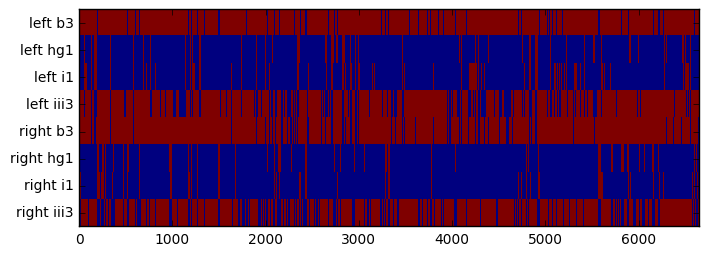

In [16]:
plt.figure(figsize = (8,2.8))
plt.imshow(train_dset[:,0:5000].T,aspect = 'auto',interpolation = 'nearest')
plt.gca().set_yticks(range(len(sorted_keys)))
lbs = plt.gca().set_yticklabels(['%s %s'%k for k in sorted_keys])

In [659]:
#tsne = TSNE(n_components=2)
#X_embedded = tsne.fit_transform(train_dset)

In [660]:
#ds = DBSCAN(min_samples = 20,eps = 0.1).fit(X_embedded)

In [661]:
#ds = DBSCAN(metric=dist,min_samples = 20,eps = 0.0001).fit(train_dset)

In [662]:
#ds.labels_

In [663]:
#colors = plt.cm.prism(ds.labels_/45.)#np.max(ds.labels_))

In [664]:
#colors[ds.labels_ == -1] = [0,0,0,1]

In [665]:
#plt.scatter(X_embedded[:,0],X_embedded[:,1],c = colors, edgecolors='None',alpha = 0.1)

In [666]:
#np.max(ds.labels_)

In [17]:
tprob = {}

In [18]:
train_dset = train_dset.astype(int)

In [19]:
state_list = [tuple(row) for row in train_dset]
state_set = set(state_list)

In [21]:
state_counts = {}
for state in state_set:
    state_counts[state] = np.sum(np.sum(state==train_dset,axis = 1)==8)

In [23]:
tprob = {}
for row1,row2 in zip(train_dset[:-1],train_dset[1:]):
    if (tuple(row1),tuple(row2)) in tprob.keys():
        tprob[tuple(row1),tuple(row2)] += 1
    else:
        tprob[tuple(row1),tuple(row2)] = 1

In [24]:
filtered = {}
for key,tnum in tprob.items():
    if (tnum > 1) and (state_counts[key[0]] >10) and (state_counts[key[1]]>10):
        filtered[key] = tnum

In [25]:
inkeys = [x[0] for x in filtered.keys()]
outkeys = [x[1] for x in filtered.keys()]

In [26]:
filterd_set = list(set(inkeys + outkeys))

In [27]:
transition_mtrx = np.zeros((len(filterd_set),len(filterd_set)))

In [28]:
np.shape(transition_mtrx)

(31, 31)

In [29]:
for i,state1 in enumerate(filterd_set):
    for j,state2 in enumerate(filterd_set):
        try:
            transition_mtrx[i,j] = filtered[state1,state2]
        except KeyError:
            pass

In [30]:
transition_prob = transition_mtrx/np.sum(transition_mtrx,axis = 1)[:,None]
transition_prob[np.isnan(transition_prob)] = 0

In [32]:
sidx = np.argsort(np.diag(transition_prob))[::-1]

In [72]:
filterd_set[4]

(1, 0, 0, 1, 0, 0, 0, 1)

In [105]:
def to_mstr(state_tuple):
    return ([{0:' ',1:' %s%-3s'%(sorted_keys[i][0][0],sorted_keys[i][1])}[s] for i,s in enumerate(state_tuple)])

/home/imager/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


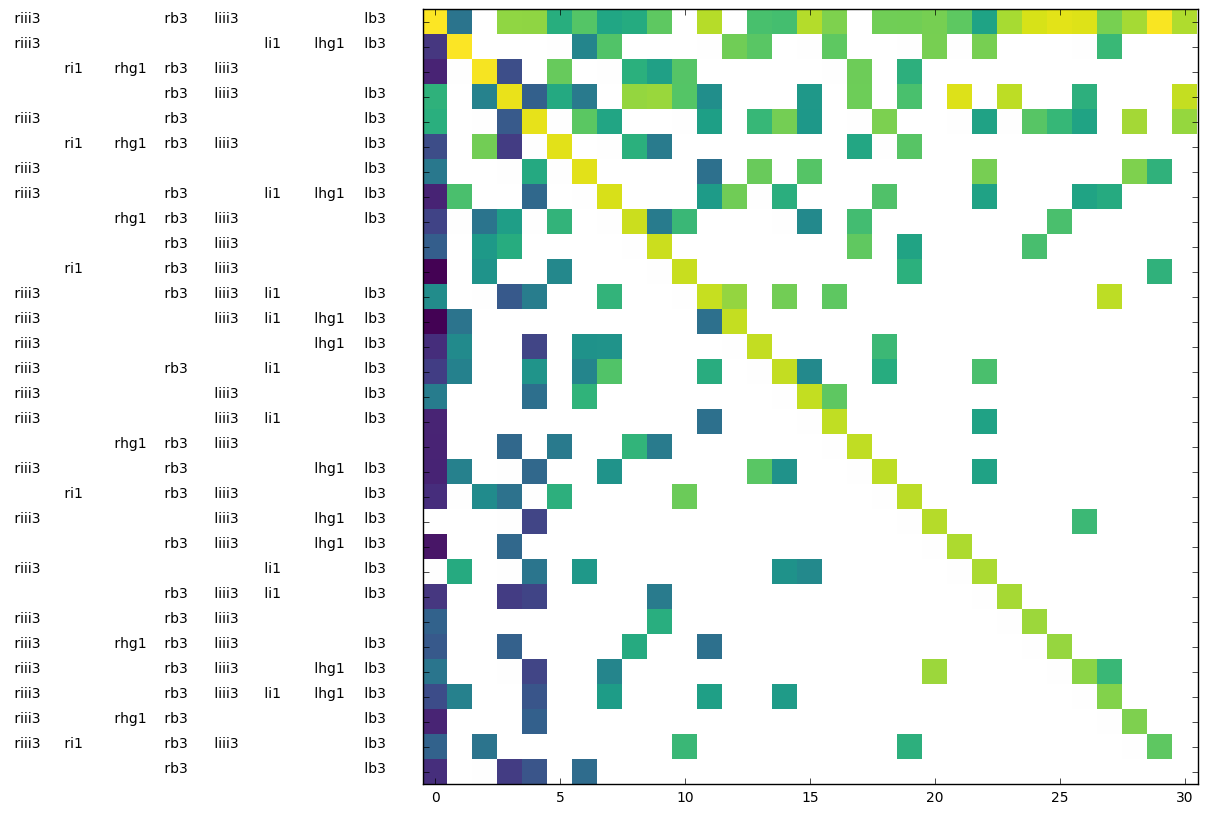

In [175]:
fig = plt.figure(figsize = (10,10))
plt.imshow(np.log(transition_prob[sidx].T[sidx]),interpolation = 'none',
          cmap = plt.cm.viridis)
#plt.imshow(transition_prob[sidx].T[sidx],interpolation = 'none',
#          cmap = plt.cm.viridis)
plt.gca().set_yticks(range(len(filterd_set)))
#lbs = plt.gca().set_yticklabels([to_mstr(filterd_set[i]) for i in sidx])
for row,idx in enumerate(sidx):
    state = filterd_set[idx]
    for i,onoff in enumerate(state):
        plt.text(-2*i -3,row,{0:'',1:' %s%-3s'%(sorted_keys[i][0][0],sorted_keys[i][1])}[onoff])
lbs = plt.gca().set_yticklabels(['' for i in sidx])

In [126]:
state_table = np.array(filterd_set)[sidx,:]

In [155]:
def next_state(current_state,state_table,tmtrx):
    from numpy import random
    state_idx = np.squeeze(np.argwhere(np.all(state_table == current_state,axis = 1)))
    prob_vector = tmtrx[:,state_idx]
    idx = random.choice(np.arange(len(state_table)),p = prob_vector)
    return state_table[idx]

In [156]:
tmtrx = transition_prob[sidx].T[sidx]

In [168]:
state_list = [[1,0,1,0,1,0,0,1]]
for i in range(5000):
    state_list.append(next_state(state_list[-1],state_table,tmtrx))

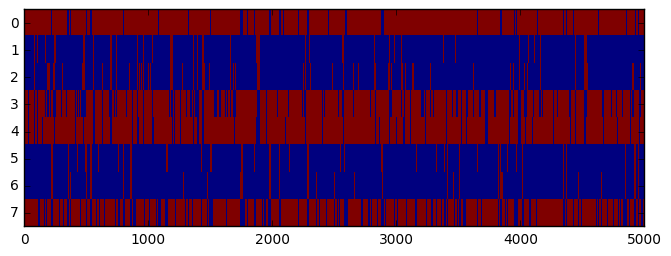

In [169]:
plt.figure(figsize = (8,2.8))
plt.imshow(np.array(state_list).T,aspect = 'auto',interpolation = 'nearest')